# Parsing Hytec results and plotting

In [1]:
import pandas as pd
from plot_hytec import *

import matplotlib.pyplot as plt  # plt.FUNCTIONNAE
import numpy as np  # outils numériques
import pandas as pd

import os

##  Defintion of the scope

In [2]:
is1D_x = False 	#1s1D_x = False # si c'est 1D en y
fig_dynamic = False
plotAcidity = False
generic_title = "Enviro_" # pour mettre un titre global
profile_sample = [2, 4]  # si tu veux aucun profile_sample, faut écrire: profile_sample = []
folder = []
#folder.append(Simulation("TSU13_Prodata", legend_label="Enviro_Prodata",color="orange"))
folder.append(Simulation("data", legend_label="Enviro_Chess",color="b"))

node_list = [ 3 ]  # [] si tu veux pas de node_list # numero du noeud
fnode_list = [3 ]  # [] si tu veux pas de node_list # numero du noeud
lag_time = 0 # tjs en année
ListOfVariables = []

if(is1D_x):
    ListOfVariables.append(plot_var("x-distance",unit = "(m)",fancy_name=" x (m)",to_plot=False,transient=False))
else:
    ListOfVariables.append(plot_var("y-distance",unit = "(m)",fancy_name=" y (m)",to_plot=False,transient=False))

ListOfVariables.append(plot_var("pH", ymin=1, ymax=9))  # tmin et tmax = sample
#	ListOfVariables.append(plot_var("Eh"))
#	ListOfVariables.append(plot_var("aqueous{Ca[2+]}",fancy_name="Ca(aq)", fname = "Ca(aq)",type_sort=1,color="r"))
#	ListOfVariables.append(plot_var("aqueous{Mg[2+]}",fancy_name="Mg(aq)", fname = "Mg(aq)",type_sort=1,color="g"))
ListOfVariables.append(plot_var("aqueous{UO2[2+]}",fancy_name="UO2(aq)", fname = "UO2(aq)", logscale= True, type_sort=1,color="b"))
ListOfVariables.append(plot_var("aqueous{SO4[2-]}",fancy_name="SO4(aq)", fname = "SO4(aq)", logscale= True, type_sort=1,color="orange"))
#	ListOfVariables.append(plot_var("aqueous{K[+]}",fancy_name="K(aq)", fname = "K(aq)", type_sort=1,color="c"))
#	ListOfVariables.append(plot_var("aqueous{Na[+]}", fancy_name="Na(aq)", fname = "Na(aq)", type_sort=1,color="m"))
ListOfVariables.append(plot_var("fixed{H[+]}", fancy_name="Fixed H+", fname = "Fixed H+",  type_sort=2,color="k"))
ListOfVariables.append(plot_var("fixed{Ca[2+]}",fancy_name="Fixed Ca++", fname = "Fixed Ca++",type_sort=2,color="r"))
ListOfVariables.append(plot_var("fixed{Mg[2+]}",fancy_name="Fixed Mg++", fname = "Fixed Mg++",type_sort=2,color="g"))
ListOfVariables.append(plot_var("fixed{UO2[2+]}",fancy_name="Fixed UO2++", fname = "Fixed UO2++", type_sort=2,color="b"))
ListOfVariables.append(plot_var("fixed{K[+]}",fancy_name="Fixed K+", fname = "Fixed K+",type_sort=2,color="c"))
ListOfVariables.append(plot_var("fixed{Na[+]}",fancy_name="Fixed Na+", fname = "Fixed Na+",type_sort=2,color="m"))


Combined_plot_properties = []
Combined_plot_properties.append(Combined_plot("Aqueous","aq","Aqueous (mol/L)",logscale=True))
Combined_plot_properties.append(Combined_plot("Sorbed","fix","Sorbed (mol/L)",logscale=True))

FluxVariables = []
FluxVariables.append(plot_var("aqueous{UO2[2+]}", fname = "U(t)", unit = "T", fac = 0.000238,tmin=0, tmax=8, ymin=0, ymax=2))
if(plotAcidity):
    FluxVariables.append(plot_var("acidity",acidity=True,unit = "kg",tmin=0,tmax=8,ymin=0,ymax=2))

transient_data = []
profile_data = []
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#print("number of colors in cycle is %d" %(len(colors)))
for i in range(len(ListOfVariables)):
    if(ListOfVariables[i].color==""):
        ListOfVariables[i].color = "b"
    if(ListOfVariables[i].transient):
        transient_data.append(ListOfVariables[i])            
    if(ListOfVariables[i].profile):
        profile_data.append(ListOfVariables[i])

for i in range(len(folder)):
    if(folder[i].color==""):
        folder[i].color=colors[i]
for i in range(len(FluxVariables)):
    if(FluxVariables[i].color==""):
        FluxVariables[i].color=colors[i]
Profile_res = []
Transient_res = []
profile_data_names = []
transient_data_names = []

for i in range(len(profile_data)):
    profile_data_names.append(profile_data[i].name)

for i in range(len(transient_data)):
    transient_data_names.append(transient_data[i].name)

## Parsing data

In [3]:
NumberOfSampleTimes = 0
for i in range(len(folder)):
    fold = folder[i].fold
    data, dict_col_unit, row_number = read_data(os.path.join(fold, 'HYTEC.res'))
    varNames = dict_col_unit['column_name'].values
    units = dict_col_unit['unit'].values
    sTimes = data['time'].unique()
    Nnodes = len(data['y-distance'].unique())
    if i == 0:
        Sample_times = np.zeros((len(folder), len(sTimes)))

    if len(sTimes) > NumberOfSampleTimes:
        if i == 0:
            Sample_times = np.zeros((len(folder), len(sTimes)))
        else:
            Sample_times = extend_vector(
                Sample_times, len(sTimes), len(folder), NumberOfSampleTimes
            )
        NumberOfSampleTimes = len(sTimes)

    # print(sTimes)
    # print(len(Sample_times))
    # print(len(Sample_times[0]))
    for k in range(len(sTimes)):
        Sample_times[i][k] = sTimes[k]

    for sam in range(len(profile_sample)):
        Profile_res.append(data.loc[data['time']==data['time'].unique()[profile_sample[sam]], profile_data_names])

        # 2. get data for transient plots
    for node in node_list:
        Transient_res.append(data.loc[data['y-distance']== node, transient_data_names])
  

In [4]:
render_time = []
t_unit = []
for i in range(len(sTimes)):
    if sTimes[i] < 3600 * 24:
        render_time.append(int(sTimes[i]) - lag_time * 365 * 3600 * 24)
        if render_time[len(render_time) - 1] == 1:
            t_unit.append("second")
        else:
            t_unit.append("seconds")
    elif sTimes[i] < 3600 * 24 * 30:
        render_time.append(int(sTimes[i] / 3600 / 24) - lag_time * 365)
        if render_time[len(render_time) - 1] == 1:
            t_unit.append("day")
        else:
            t_unit.append("days")
    elif sTimes[i] < 3600 * 24 * 365:
        render_time.append(int(sTimes[i] / 3600 / 24 / 30) - lag_time * 12)
        if render_time[len(render_time) - 1] == 1:
            t_unit.append("month")
        else:
            t_unit.append("months")
    else:
        render_time.append(int(sTimes[i] / 3600 / 24 / 365) - lag_time)
        if render_time[len(render_time) - 1] == 1:
            t_unit.append("year")
        else:
            t_unit.append("years")

plot_t_unit = []
# plot_time = []
if sTimes[len(sTimes) - 1] < 3600 * 24:
    fac = 1
    plot_t_unit = "seconds"
elif sTimes[len(sTimes) - 1] < 3600 * 24:
    fac = 3600 * 24
    plot_t_unit = "days"
elif sTimes[len(sTimes) - 1] < 3600 * 24 * 365:
    fac = 3600 * 24 * 12
    plot_t_unit = "months"
elif sTimes[len(sTimes) - 1] >= 3600 * 24 * 365:
    fac = 3600 * 24 * 365
    plot_t_unit = "years"

## Plotting  distance profile for a specific date

In [5]:
for j in range(len(folder)):
        sTimes = Sample_times[j][:]
        for i in range(len(sTimes)):
            if sTimes[i] == 0 and i > 1:
                i = len(sTimes)
            else:
                folder[j].plot_time.append(
                    (sTimes[i] - lag_time / 3600 / 24 / 365) / fac
                )

for i in range(len(profile_sample)):
    for j in range(len(profile_data)):
        if profile_data[j].to_plot:
            if fig_dynamic:
                pass
            else:
                fig, ax = plt.subplots()
                for f in range(len(folder)):
                    df = Profile_res[i + f * (len(profile_sample))]
                    if is1D_x:
                        xval = df["x-distance"]
                        xlab = "x-distance (m)"
                    else:
                        xval = df["y-distance"]
                        xlab = "y-distance (m)"
                    if len(folder) > 1:
                        plot_color = folder[f].color
                    else:
                        plot_color = profile_data[j].color
                    if profile_data[j].logscale:
                        if profile_data[j].name in df.columns:
                            plt.semilogy(
                                xval,
                                profile_data[j].fac * df[profile_data[j].name],
                                label=str(folder[f].legend_label),
                                color=plot_color,
                            )
                    else:
                        if profile_data[j].name in df.columns:
                            plt.plot(
                                xval,
                                profile_data[j].fac * df[profile_data[j].name],
                                label=str(folder[f].legend_label),
                                color=plot_color,
                            )

                if profile_data[j].setxmax == True:
                    ax.set_xlim(right=profile_data[j].xmax)
                if profile_data[j].setxmin == True:
                    ax.set_xlim(left=profile_data[j].xmin)
                if profile_data[j].setymax == True:
                    ax.set_ylim(top=profile_data[j].ymax)
                if profile_data[j].setxmin == True:
                    ax.set_ylim(bottom=profile_data[j].ymin)

                title = (
                    str(profile_data[j].fancy_name)
                    + " after "
                    + str(render_time[profile_sample[i]])
                    + " "
                    + t_unit[profile_sample[i]]
                )
                plt.xlabel(xlab)
                ylab = (
                    profile_data[j].fancy_name + " (" + profile_data[j].unit + ")"
                ) 
                plt.ylabel(ylab)
                plt.suptitle(title)
                ax.legend()

                filename = (
                    generic_title
                    + str(profile_data[j].fname)
                    + "_sample"
                    + str(profile_sample[i])
                    + ".png"
                )
                fname = "".join(filename)
                if len(folder) == 1:
                    plt.savefig(str(filename), dpi=500)  # ,transparent=True)
                else:
                    plt.savefig(str(filename), dpi=500)  # ,transparent=True)
                plt.close()


## Plotting time profile for a specific node

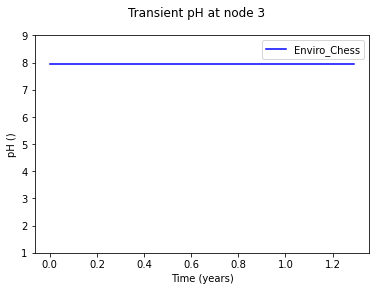

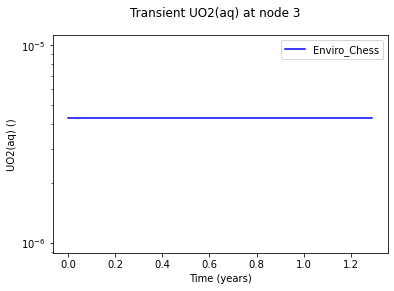

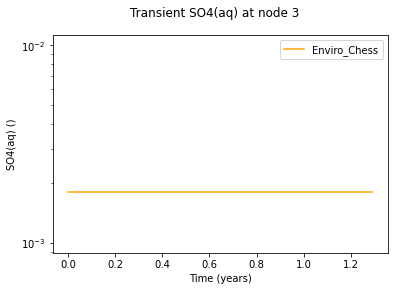

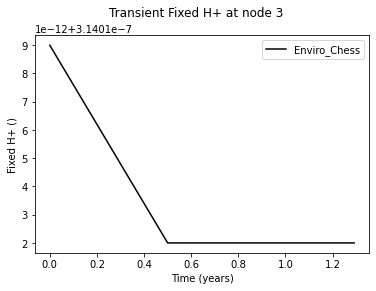

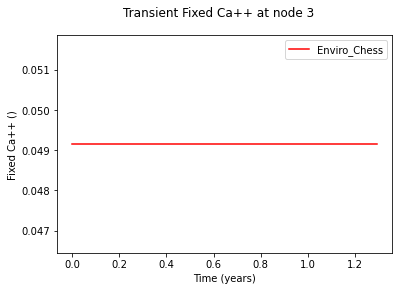

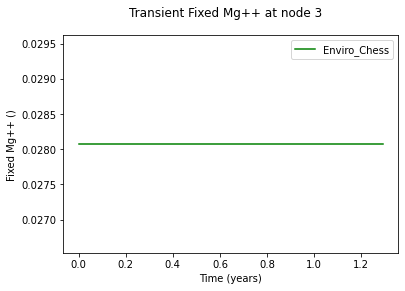

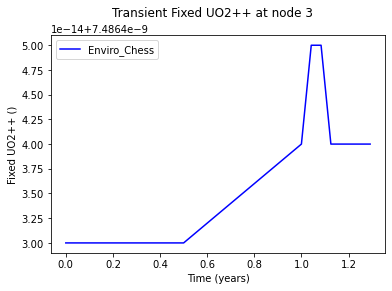

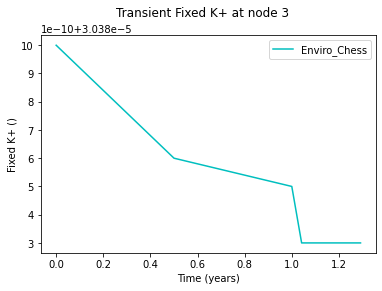

In [6]:
for i in range(len(node_list)):
        for j in range(len(transient_data)):
            fig, ax = plt.subplots()
            for f in range(len(folder)):
                df = Transient_res[i + f * len(node_list)]
                if len(folder) > 1:
                    plot_color = folder[f].color
                else:
                    plot_color = transient_data[j].color
                if transient_data[j].logscale:
                    if transient_data[j].name in df.columns:
                        plt.semilogy(
                            folder[f].plot_time,
                            transient_data[j].fac * df[transient_data[j].name],
                            label=str(folder[f].legend_label),
                            color=plot_color,
                        )
                else:
                    if transient_data[j].name in df.columns:
                        plt.plot(
                            folder[f].plot_time,
                            transient_data[j].fac * df[transient_data[j].name],
                            label=str(folder[f].legend_label),
                            color=plot_color,
                        )

            if transient_data[j].settmax == True:
                ax.set_xlim(right=folder[f].plot_time[transient_data[j].tmax])
            if transient_data[j].settmin == True:
                ax.set_xlim(left=folder[f].plot_time[transient_data[j].tmin])

            if transient_data[j].setymax == True:
                ax.set_ylim(top=transient_data[j].ymax)
            if transient_data[j].setymin == True:
                ax.set_ylim(bottom=transient_data[j].ymin)

            title = str(
                "Transient "
                + transient_data[j].fancy_name
                + " at node "
                + str(node_list[i])
            )
            xlab = "Time (" + plot_t_unit + ")"
            plt.xlabel(xlab)
            ylab = transient_data[j].fancy_name + " (" + transient_data[j].unit + ")"
            plt.ylabel(ylab)
            plt.suptitle(title)
            ax.legend()

            filename = (
                generic_title
                + str(transient_data[j].fname)
                + "_node"
                + str(node_list[i])
                + ".png"
            )
            fname = "".join(filename)
            # print(fname)
            if len(folder) == 1:
                plt.savefig(str(filename), dpi=500)  # ,transparent=True)
                # plt.clf()
            else:
                plt.savefig(str(filename), dpi=500)  # ,transparent=True)
        plt.close()

## Combined plots

Enviro_aq_sample2.png
Enviro_aq_sample4.png
Enviro_fix_sample2.png
Enviro_fix_sample4.png


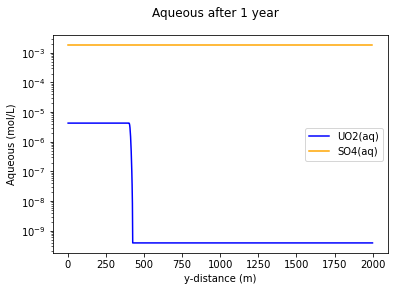

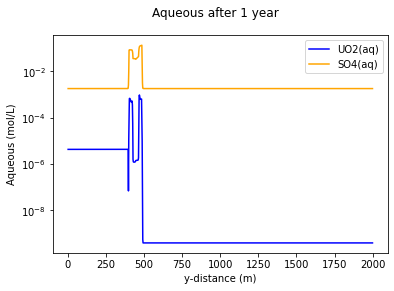

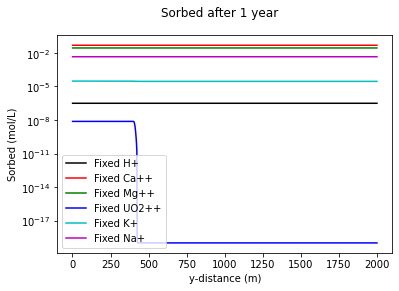

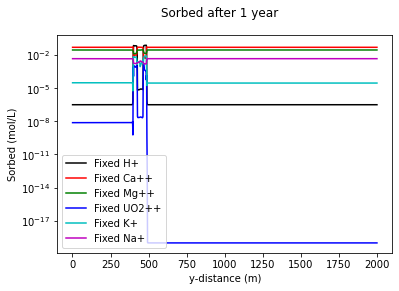

In [7]:
max_sort = 0
for i in range(len(profile_data)):
    if profile_data[i].type_sort > max_sort:
        max_sort = profile_data[i].type_sort

for f in range(len(folder)):
    for sort in range(1, max_sort + 1):
        for i in range(len(profile_sample)):
            # for j in range(1,max_sort):
            fig, ax = plt.subplots()
            df = Profile_res[i + f * (len(profile_sample))]
            if is1D_x:
                xval = df["x-distance"]
                xlab = "x-distance (m)"
            else:
                xval = df["y-distance"]
                xlab = "y-distance (m)"

            for j in range(len(profile_data)):
                if profile_data[j].type_sort == sort:
                    plot_color = profile_data[j].color
                    if profile_data[j].name in df:
                        if Combined_plot_properties[sort - 1].logscale == True:
                            plt.semilogy(
                                xval,
                                profile_data[j].fac * df[profile_data[j].name],
                                label=profile_data[j].fancy_name,
                                color=plot_color,
                            )
                        else:
                            plt.plot(
                                xval,
                                profile_data[j].fac * df[profile_data[j].name],
                                label=profile_data[j].fancy_name,
                                color=plot_color,
                            )
            title = (
                Combined_plot_properties[sort - 1].title
                + " after "
                + str(render_time[profile_sample[i]])
                + " "
                + t_unit[profile_sample[i]]
            )
            plt.xlabel(xlab)
            ylab = Combined_plot_properties[sort - 1].ylab
            plt.ylabel(ylab)
            plt.suptitle(title)
            ax.legend()
            fn = Combined_plot_properties[sort - 1].fname
            filename = (
                generic_title + fn + "_sample" + str(profile_sample[i]) + ".png"
            )
            fname = "".join(filename)
            print(fname)
            plt.savefig(str(filename), dpi=500)  # ,transparent=True)


## Parsing flux data

In [8]:
Flux_res = []
flux_data_names = []

for i in range(len(FluxVariables)):
    flux_data_names.append(FluxVariables[i].name)
if len(FluxVariables) > 0:
    for i in range(len(folder)):
        fold = folder[i].fold
        data_2, dict_col_unit_2, row_number_2 = read_data(os.path.join(fold, 'HYTEC.flc'))
        data_2.reset_index(inplace=True, drop=True)
        fsTimes = data_2['time'].values
        Flux_res.append(data_2)


## Plotting flux data

Enviro_FluxCum_U(t).png


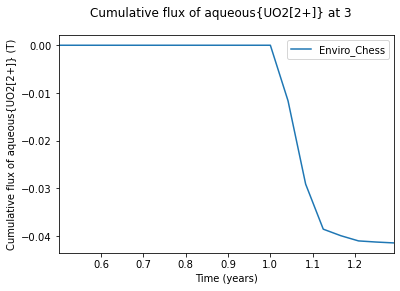

In [9]:

fplot_time = fsTimes[::3] / 3600 / 24 / 365


for i in range(len(fnode_list)):
    for j in range(len(FluxVariables)):
        fig, ax = plt.subplots()
        for f in range(len(folder)):
            dff = Flux_res[f]
            df = dff.loc[dff["Loc"] == fnode_list[i]]
            if len(folder) > 1:
                plot_color = folder[f].color
            else:
                plot_color = FluxVariables[j].color
            if FluxVariables[j].acidity:
                acidity = (
                    df["H[+]"] * 0.001
                    + df["HSO4[-]"] * 0.097
                    + 2 * df["H2SO4(aq)"] * 0.098
                )
                plt.plot(
                    fplot_time,
                    acidity,
                    label=str(folder[f].legend_label),
                    color=plot_color,
                )
            else:
                plt.plot(
                    fplot_time,
                    FluxVariables[j].fac * df[FluxVariables[j].name],
                    label=str(folder[f].legend_label),
                    color=plot_color,
                )

        if FluxVariables[j].settmax == True:
            ax.set_xlim(right=fplot_time[FluxVariables[j].tmax])
        if FluxVariables[j].settmin == True:
            ax.set_xlim(left=fplot_time[FluxVariables[j].tmin])
        title = (
            "Cumulative flux of "
            + FluxVariables[j].fancy_name
            + " at "
            + str(fnode_list[i])
        )
        xlab = "Time (years)"
        plt.xlabel(xlab)
        ylab = (
            "Cumulative flux of "
            + FluxVariables[j].fancy_name
            + " ("
            + FluxVariables[j].unit
            + ")"
        )
        plt.ylabel(ylab)
        plt.suptitle(title)
        ax.legend()

        filename = (
            generic_title + "FluxCum_" + str(FluxVariables[j].fname) + ".png"
        )
        fname = "".join(filename)
        print(fname)
        if len(folder) == 1:
            plt.savefig(str(fname), dpi=500)  # ,transparent=True)
            # plt.clf()
        else:
            plt.savefig(str(fname), dpi=500)  # ,transparent=True)